ME 592X Term Project

Mount to Google Drive where the data files are stored. Be sure to change runtime to GPU for faster model training

In [6]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/ME592/Project', nb_path)
sys.path.insert(0, nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


FileExistsError: ignored

Import the required modules

In [7]:
# import modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.core import Activation
import matplotlib.pyplot as plt

Data Preprocessing

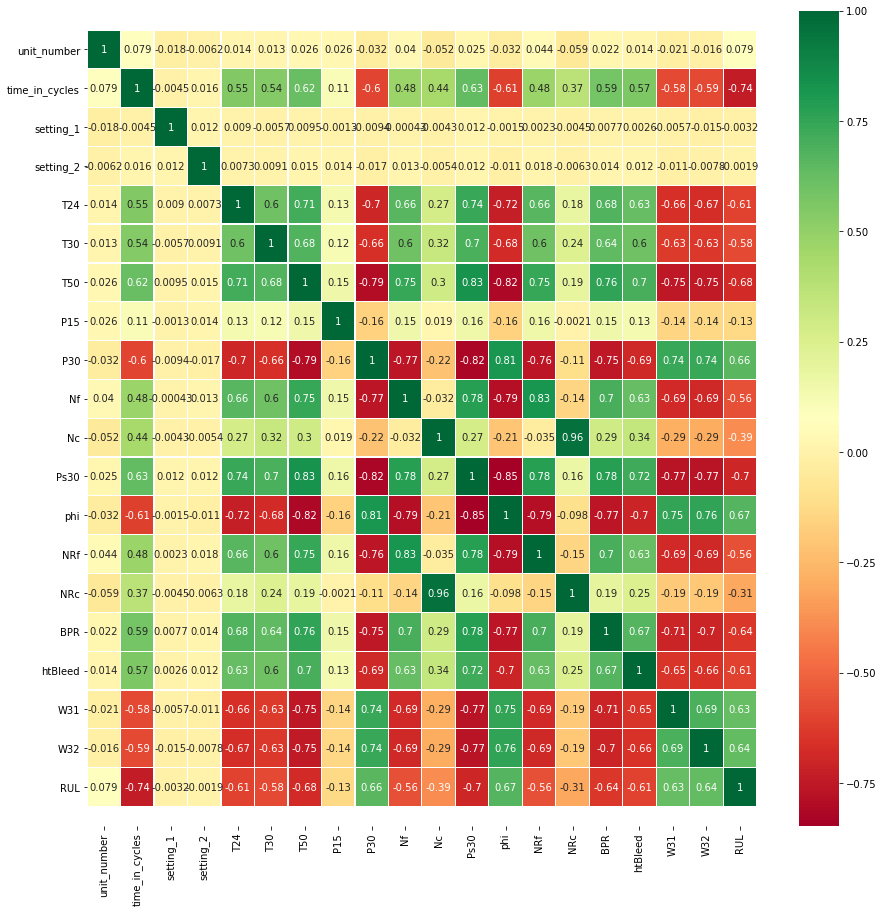

In [8]:
# load the data files
train_df = pd.read_csv(r"/content/mnt/My Drive/Colab Notebooks/ME592/Project/train_FD001.txt", sep=" ", header=None)
test_df = pd.read_csv(r"/content/mnt/My Drive/Colab Notebooks/ME592/Project/test_FD001.txt", sep=" ", header=None)
test_y_df = pd.read_csv(r"/content/mnt/My Drive/Colab Notebooks/ME592/Project/RUL_FD001.txt", sep=" ", header=None)

# create variables so we can view the data file contents
a = train_df.describe()
b = test_df.describe()
c = test_df.describe()

# notice that the last 2 columns of train_x_df and test_x_df are NaN's, so drop them
# also notice the last column of train_y_df is NaN's so drop it as well
train_df.drop(columns=[26,27], inplace=True)
test_df.drop(columns=[26,27], inplace=True)
test_y_df.drop(columns=[1], inplace=True)

# name the data columns as per the data description
column_names = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
train_df.columns = column_names
test_df.columns = column_names
test_y_df.columns = ['RUL']

# recreate variables so we can view the data file contents
a = train_df.describe()
b = test_df.describe()
c = test_df.describe()
a.columns = train_df.columns
b.columns = test_df.columns
c.columns = test_df.columns

# notice that some columns contain only constant values and won't help predict the remaining life
# remove these columns
train_df.drop(columns=['TRA','T2','P2','epr','farB','Nf_dmd','PCNfR_dmd'], inplace=True)                     
test_df.drop(columns=['TRA','T2','P2','epr','farB','Nf_dmd','PCNfR_dmd'], inplace=True)


# create a remaining useful life column for training data
# note that in the training data each unit runs until failure
# we can calculate the RUL by subtracting the cycle count from the max cycles
# for a given unit
d = train_df.copy()
e = d.groupby('unit_number')['time_in_cycles'].max().reset_index()
e.columns = ['unit_number','max_cycles']
f = d.merge(e, on=['unit_number'], how='left')
f['RUL'] = f['max_cycles'] - f['time_in_cycles']
train_df['RUL'] = f['RUL']

# create a remaining useful life column for the test data
# note that in the test data each unit runs for some amount of time, but not all
# the way to failure. The RUL at the end of each run was in the 'RUL_FD00X' file
# we can calculate the RUL at each timestep using this information.
g = test_df.copy()
h = g.groupby('unit_number')['time_in_cycles'].max().reset_index()
h.columns = ['unit_number','cycles_at_end_of_test']
i = g.merge(h, on=['unit_number'], how='left')
j = test_y_df.copy()
j['unit_number'] = j.index+1
j.columns = ['RUL_at_end_of_test', 'unit_number']
k = i.merge(j, on=['unit_number'], how='left')
k['max_cycles'] = k['cycles_at_end_of_test'] + k['RUL_at_end_of_test']
k['RUL'] = k['max_cycles'] - k['time_in_cycles']
test_df['RUL'] = k['RUL']

## create a correlation heatmap to for the training data
plt.figure(figsize=(15, 15))
fig = sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
bottom, top = fig.get_ylim()
fig.set_ylim(bottom + 0.5, top - 0.5)
fig.figsize=(15,15)
plt.show

# notice that 'unit_number', 'setting_1', 'setting_2', and 'P15' are weakly correlated to RUL
# also notice that 'Nc' and NRc are highly correlated to each other
# remove all of the columns that are weakly correlated to RUL except unit number becuase unit number is needed for sequencing later
# remove 'NRc' becuase it is largely redundant data with Nc
train_df.drop(columns=['setting_1','setting_2','P15','NRc'], inplace=True)
test_df.drop(columns=['setting_1','setting_2','P15','NRc'], inplace=True)

# normalize the training data (except for unit number and RUL)
min_max_scaler = MinMaxScaler()
l = train_df.copy()
train_df_normalized = pd.DataFrame(min_max_scaler.fit_transform(l), index=l.index)
train_df_normalized.columns = train_df.columns
train_df_normalized['unit_number'] = train_df['unit_number']
train_df_normalized['RUL'] = train_df['RUL']

# normalize the test data (except for unit number and RUL)
m = test_df.copy()
test_df_normalized = pd.DataFrame(min_max_scaler.transform(m), index=m.index)
test_df_normalized.columns = test_df.columns
test_df_normalized['unit_number'] = test_df['unit_number']
test_df_normalized['RUL'] = test_df['RUL']

# select a sequence length
seq_length = 50

# sequence the training data
# drop any time series that are shorter than seq_length
sequenced_x = []
sequenced_y = []
for i in train_df_normalized['unit_number'].unique():  
    x = train_df_normalized[train_df_normalized['unit_number']==i].copy()
    if len(x) > seq_length:
        x.drop('unit_number', axis=1, inplace=True)
        y = x['RUL']
        x.drop('RUL', axis=1, inplace=True)
        b = TimeseriesGenerator(x.values, y.values, seq_length, batch_size = 99999)
        c = b[0]
        sequenced_x.append(c[0])
        sequenced_y.append(c[1])
train_x_normalized_sequenced = np.concatenate(sequenced_x).astype(np.float32)
train_y_normalized_sequenced = np.concatenate(sequenced_y).astype(np.float32)

# sequence the test data
# drop any time series that are shorter than seq_length
# use only the last sequence to make predictions
sequenced_x = []
sequenced_y = []
for i in test_df_normalized['unit_number'].unique():
    x = test_df_normalized[test_df_normalized['unit_number']==i].copy()
    if len(x) > seq_length:
        x.drop('unit_number', axis=1, inplace=True)
        y = x['RUL']
        x.drop('RUL', axis=1, inplace=True)
        b = TimeseriesGenerator(x.values, y.values, seq_length, batch_size = 99999)
        c = b[0]
        sequenced_x.append(c[0][-1,:,:])
        sequenced_y.append(c[1][-1])
test_x_normalized_sequenced = np.concatenate(sequenced_x).astype(np.float32).reshape(len(sequenced_x),seq_length,14)
test_y_normalized_sequenced = np.array(sequenced_y).astype(np.float32)

Define the model

In [9]:
# define the model
n_features = train_x_normalized_sequenced.shape[2]
hidden_dim = 100
output_dim = 1
model = Sequential()
model.add(LSTM(input_shape = (seq_length, n_features), units = hidden_dim, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units = output_dim))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mean_absolute_percentage_error'])

epochs = 50
batch_size = 200
validation_split = 0.05
verbose = 2

Train the model

Epoch 1/50
75/75 - 6s - loss: 8822.8887 - mae: 75.2246 - mean_absolute_percentage_error: 67432552.0000 - val_loss: 8241.1699 - val_mae: 72.3561 - val_mean_absolute_percentage_error: 81783128.0000
Epoch 2/50
75/75 - 2s - loss: 8154.5454 - mae: 71.3495 - mean_absolute_percentage_error: 94620936.0000 - val_loss: 7717.1074 - val_mae: 69.3111 - val_mean_absolute_percentage_error: 105945976.0000
Epoch 3/50
75/75 - 2s - loss: 7634.6318 - mae: 68.3447 - mean_absolute_percentage_error: 114981512.0000 - val_loss: 7215.9180 - val_mae: 66.4155 - val_mean_absolute_percentage_error: 130393576.0000
Epoch 4/50
75/75 - 2s - loss: 7148.3315 - mae: 65.5711 - mean_absolute_percentage_error: 144005456.0000 - val_loss: 6748.5166 - val_mae: 63.7322 - val_mean_absolute_percentage_error: 154599264.0000
Epoch 5/50
75/75 - 2s - loss: 6691.7368 - mae: 62.9778 - mean_absolute_percentage_error: 168363392.0000 - val_loss: 6310.3120 - val_mae: 61.2352 - val_mean_absolute_percentage_error: 178774560.0000
Epoch 6/50
75

Text(0.5, 1.0, 'Loss during Training')

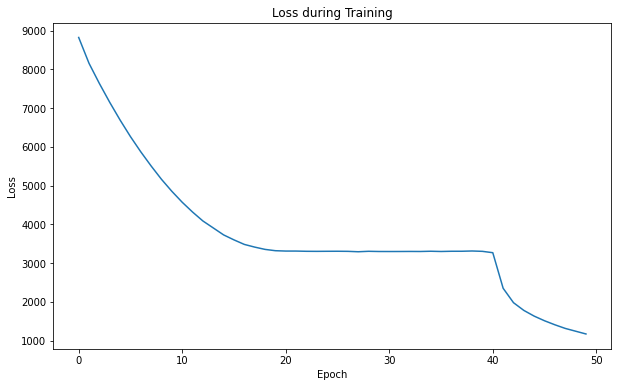

In [10]:
# train the model
history = model.fit(train_x_normalized_sequenced, train_y_normalized_sequenced, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)

# plot the training losses over time
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')

Test the model

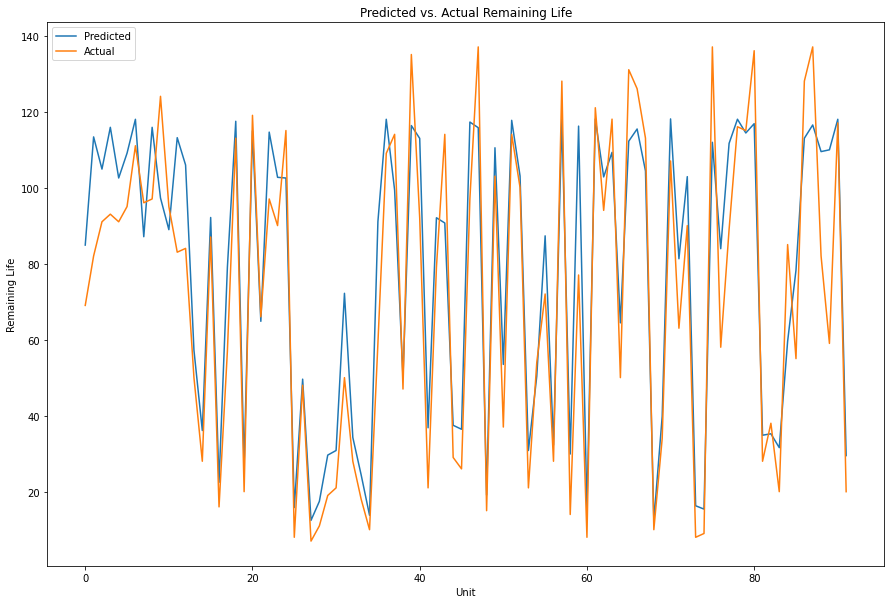

In [12]:
# predict the RUL for the test data
estimator = model
y_pred_test = estimator.predict(test_x_normalized_sequenced)
y_true_test = test_y_normalized_sequenced

# plot the predicted RUL and the actual RUL
plt.figure(figsize=(15,10))
plt.plot(y_pred_test)
plt.plot(y_true_test)
plt.xlabel('Unit')
plt.ylabel('Remaining Life')
plt.title('Predicted vs. Actual Remaining Life')
plt.legend(['Predicted','Actual'])


Evaluate the impact that different parameters have on the model accuracy

In [13]:
# evaluate the impact that the number of epochs
# run each model 5 times due to randomness of initialization
epochs = [100,125,150]

for epoch in epochs:  
  print("Number of Epochs: " + str(epoch))
  print("-------------------------")
  for i in range(5):
    history = model.fit(train_x_normalized_sequenced, train_y_normalized_sequenced, epochs=epoch, batch_size=200, validation_split=validation_split, verbose=0)
    mse = model.evaluate(test_x_normalized_sequenced,test_y_normalized_sequenced)

# notice that as the number of epochs increases the accuracy increases


  


Number of Epochs: 100
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 697.5122 - mae: 15.6462 - mean_absolute_percentage_error: 20.7854
Number of Epochs: 125
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 473.1461 - mae: 13.5809 - mean_absolute_percentage_error: 19.2295
Number of Epochs: 150
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 561.8245 - mae: 15.4893 - mean_absolute_percentage_error: 20.4495


In [17]:
# evaluate the impact of batch size
# run each model 5 times due to randomness of initialization
batch_sizes = [200,300, 400, 500]

for batch_size in batch_sizes:  
  print("Batch Size: " + str(batch_size))
  print("-------------------------")
  for i in range(5):
    history = model.fit(train_x_normalized_sequenced, train_y_normalized_sequenced, epochs=50, batch_size=batch_size, validation_split=validation_split, verbose=0)
    mse = model.evaluate(test_x_normalized_sequenced,test_y_normalized_sequenced)

# notice that as the batch size increases the accuracy also increases

Batch Size: 200
-------------------------
3/3 [==============================] - 0s 8ms/step - loss: 648.9952 - mae: 15.8966 - mean_absolute_percentage_error: 20.9292
Batch Size: 300
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 1088.9094 - mae: 17.9554 - mean_absolute_percentage_error: 24.6563
Batch Size: 400
-------------------------
3/3 [==============================] - 0s 9ms/step - loss: 1009.8781 - mae: 16.8959 - mean_absolute_percentage_error: 23.8403
Batch Size: 500
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 1048.3768 - mae: 16.9012 - mean_absolute_percentage_error: 23.1770


In [19]:
# evaluate the impact of changing the size of the LSTM hidden layers
# run each model 5 times due to randomness of initialization
layer_1_features = [10,20,40,80,160]
layer_2_features = [5,10,20,40,80]

for j, feature in enumerate(layer_1_features): 
  print("Hidden Layer 1 Size: " + str(layer_1_features[j]))
  print("Hidden Layer 2 Size: " + str(layer_2_features[j]))
  print("-------------------------")
  model = Sequential()
  model.add(LSTM(input_shape = (seq_length, n_features), units = layer_1_features[j], return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=layer_2_features[j], return_sequences = False))
  model.add(Dropout(0.2))
  model.add(Dense(units = output_dim))
  model.add(Activation('linear'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mean_absolute_percentage_error'])
  for i in range(5):
    history = model.fit(train_x_normalized_sequenced, train_y_normalized_sequenced, epochs=50, batch_size=200, validation_split=validation_split, verbose=0)
    mse = model.evaluate(test_x_normalized_sequenced,test_y_normalized_sequenced)

Hidden Layer 1 Size: 10
Hidden Layer 2 Size: 5
-------------------------
3/3 [==============================] - 0s 11ms/step - loss: 1784.2847 - mae: 36.0840 - mean_absolute_percentage_error: 149.8298
Hidden Layer 1 Size: 20
Hidden Layer 2 Size: 10
-------------------------
3/3 [==============================] - 0s 9ms/step - loss: 1809.1936 - mae: 36.0943 - mean_absolute_percentage_error: 152.0496
Hidden Layer 1 Size: 40
Hidden Layer 2 Size: 20
-------------------------
3/3 [==============================] - 0s 11ms/step - loss: 680.4228 - mae: 15.7889 - mean_absolute_percentage_error: 20.7051
Hidden Layer 1 Size: 80
Hidden Layer 2 Size: 40
-------------------------
3/3 [==============================] - 0s 9ms/step - loss: 776.9167 - mae: 14.7675 - mean_absolute_percentage_error: 18.6847
Hidden Layer 1 Size: 160
Hidden Layer 2 Size: 80
-------------------------
3/3 [==============================] - 0s 9ms/step - loss: 752.9880 - mae: 14.3856 - mean_absolute_percentage_error: 20.4811

In [20]:
# evaluate the impact of changing the size of the LSTM hidden layers
# run each model 5 times due to randomness of initialization
layer_1_dropout = [0.01,0.1,0.2,0.3,0.4]
layer_2_dropout = [0.01,0.1,0.2,0.3,0.4]

for j, dropout in enumerate(layer_1_dropout): 
  print("Hidden Layer 1 Size: " + str(layer_1_dropout[j]))
  print("Hidden Layer 2 Size: " + str(layer_2_dropout[j]))
  print("-------------------------")
  model = Sequential()
  model.add(LSTM(input_shape = (seq_length, n_features), units=100, return_sequences = True))
  model.add(Dropout(layer_1_dropout[j]))
  model.add(LSTM(units=50, return_sequences = False))
  model.add(Dropout(layer_2_dropout[j]))
  model.add(Dense(units = output_dim))
  model.add(Activation('linear'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mean_absolute_percentage_error'])
  for i in range(5):
    history = model.fit(train_x_normalized_sequenced, train_y_normalized_sequenced, epochs=50, batch_size=200, validation_split=validation_split, verbose=0)
    mse = model.evaluate(test_x_normalized_sequenced,test_y_normalized_sequenced)

Hidden Layer 1 Size: 0.01
Hidden Layer 2 Size: 0.01
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 847.8670 - mae: 15.3360 - mean_absolute_percentage_error: 19.6583
Hidden Layer 1 Size: 0.1
Hidden Layer 2 Size: 0.1
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 930.4258 - mae: 16.5388 - mean_absolute_percentage_error: 22.0366
Hidden Layer 1 Size: 0.2
Hidden Layer 2 Size: 0.2
-------------------------
3/3 [==============================] - 0s 10ms/step - loss: 1063.2844 - mae: 17.8318 - mean_absolute_percentage_error: 21.7340
Hidden Layer 1 Size: 0.3
Hidden Layer 2 Size: 0.3
-------------------------
3/3 [==============================] - 0s 9ms/step - loss: 724.4186 - mae: 16.2630 - mean_absolute_percentage_error: 20.4192
Hidden Layer 1 Size: 0.4
Hidden Layer 2 Size: 0.4
-------------------------
3/3 [==============================] - 0s 8ms/step - loss: 770.7522 - mae: 15.9073 - mean_absolute_percentage_erro